In [1]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt
from termcolor import colored

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql


#Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#Geography magic
import geocoder
import googlemaps
import geopy.distance as gd
import geopandas as gpd
import shapely
from shapely.geometry import Point
import fiona
import pysal as ps
import gmplot

from IPython.display import HTML

# from mpl_toolkits.basemap import Basemap

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [3]:
taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                CASE WHEN TR.tolls IS NULL THEN TR.fare ELSE TR.fare + TR.tolls END as fare_with_tolls,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-01-01' AND '2016-01-31';""" #'2017-07-31'

In [4]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [5]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
taxi_weather_clean = sql_load.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude'
                                                    , 'dropoff_centroid_longitude', 'trip_seconds', 'trip_miles', 'fare_with_tolls'])

In [6]:
#Let's get rid of the zeroes
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] != 0.0) 
                                          & (taxi_weather_clean['trip_seconds'] != 0.0) 
                                          & (taxi_weather_clean['trip_miles'] != 0.0)]

In [7]:
taxi_weather_clean.count()[0]

1066397

## Plotting fun!

In [8]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
pickup_geopoint = list(zip(taxi_weather_clean['pickup_centroid_longitude'], taxi_weather_clean['pickup_centroid_latitude']))
dropoff_geopoint = list(zip(taxi_weather_clean['dropoff_centroid_longitude'], taxi_weather_clean['dropoff_centroid_latitude']))

taxi_weather_clean['pickup_centroid_location'] = pickup_geopoint
taxi_weather_clean['dropoff_centroid_location'] = dropoff_geopoint

taxi_weather_clean['pickup_centroid_location'] = taxi_weather_clean['pickup_centroid_location'].apply(Point)
taxi_weather_clean['dropoff_centroid_location'] = taxi_weather_clean['dropoff_centroid_location'].apply(Point);


In [9]:
#Make a geopandas dataframe
taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_clean, geometry='pickup_centroid_location')

In [10]:
lats = [taxi_weather_gdf['pickup_centroid_latitude'][50], taxi_weather_gdf['dropoff_centroid_latitude'][50]]
longs = [taxi_weather_gdf['pickup_centroid_longitude'][50], taxi_weather_gdf['dropoff_centroid_longitude'][50]]

In [11]:
longs

[-87.626214906, -87.675311622]

Text(50.375,0.5,'Latitude')

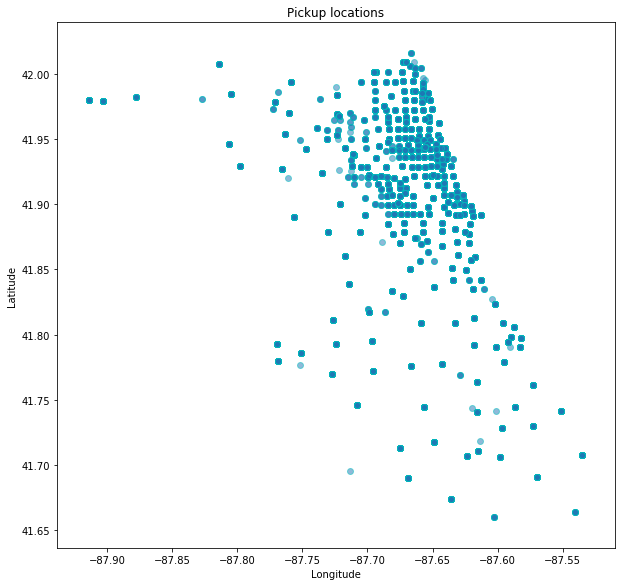

In [14]:
# Place map
# gmap = gmplot.GoogleMapPlotter.from_geocode('Chicago, USA', 12)

# # Marker
# gmap.marker(41.892507781, -87.626214906, 'cornflowerblue')

# Draw
# gmap.draw("my_map.html")

taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='c')
plt.title('Pickup locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


In [13]:
%%HTML
<iframe width="100%" height="650" src="./my_map.html"></iframe>

#### Simply drawing a map with a specified centorid location and zoom

In [ ]:
pickup_lats = list(taxi_weather_clean['pickup_centroid_latitude'])
pickup_longs = list(taxi_weather_clean['pickup_centroid_longitude'])

In [ ]:
# GoogleMapPlotter return Map object 
# Pass the center latitude and 
# center longitude 
# CC_map = gmplot.GoogleMapPlotter(41.968069, 
#                                 -87.721559063, 8 ) 

# # Pass the absolute path 
# CC_map.draw(".a/Chicago_map.html")

#### Drawing the map using geocode function

In [ ]:
# # from_geocode method return the latitude and longitude of given location
# CC_map2 = gmplot.GoogleMapPlotter.from_geocode("Chicago, USA", zoom=5) 
  
# CC_map2.draw("./Chicago_map.html") 

### Drawing routes

In [ ]:
# lats = [taxi_weather_gdf['pickup_centroid_latitude'][0], taxi_weather_gdf['dropoff_centroid_latitude'][0]]
# longs = [taxi_weather_gdf['pickup_centroid_longitude'][0], taxi_weather_gdf['dropoff_centroid_longitude'][0]]

In [ ]:
# taxi_route = gmplot.GoogleMapPlotter.from_geocode('Chicago, USA', zoom=0) 
  
# # scatter method of map object  
# # scatter points on the google map 
# taxi_route.scatter(pickup_lats, pickup_longs, '# FF0000', 
#                               size = 10, marker = True) 
  
# # Plot method Draw a line in 
# # between given coordinates 
# # taxi_route.plot(pickup_lats, pickup_longs,  
# #            'cornflowerblue', edge_width = 2.5) 
  
# taxi_route.draw("./Chicago_taxi_route.html") 